# Variational Quantum Eigensolver (VQE)

## What is it?

### My understanding

An algorithm used to find the ground state energy of a given Hamiltonian.

### [Given Definition](https://youtu.be/Z-A6G0WVI9w?feature=shared&t=127)

VQE is a hybrid algorithm, where the quantum part computes the energy, and the classical part optimizes the variational parameter.

### Hamiltonian

A Hamiltonian is just a mathematical description of the total energy of a system

## How can we train it?

In [1]:
!pip install pyscf
!pip install qiskit-aer
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install qiskit-ibm-runtime
!pip install pylatexenc
!pip install qiskit

In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [9]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService.save_account(
    channel='ibm_quantum',
    token='254505744a2e74852187d65779e05c8ca05046071c584f962c73e610ed2356512fe291667021ea501af90c1da8f6cd4d84684f951a3faf1256f4d0c068b993d1',
    set_as_default=True,
    overwrite=True
)

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

In [7]:
backend

<IBMBackend('ibm_kyoto')>

### Step 1: Map classical inputs to a quantum problem

In [ ]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

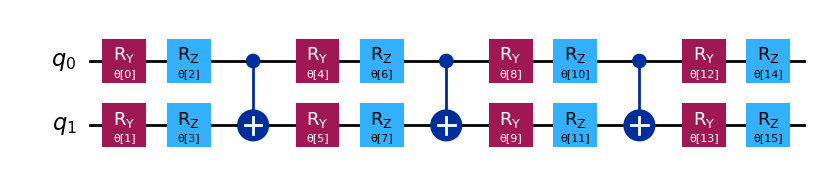

In [ ]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [ ]:
num_params = ansatz.num_parameters
num_params

16

### Step 2: Optimize problem for quantum execution

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

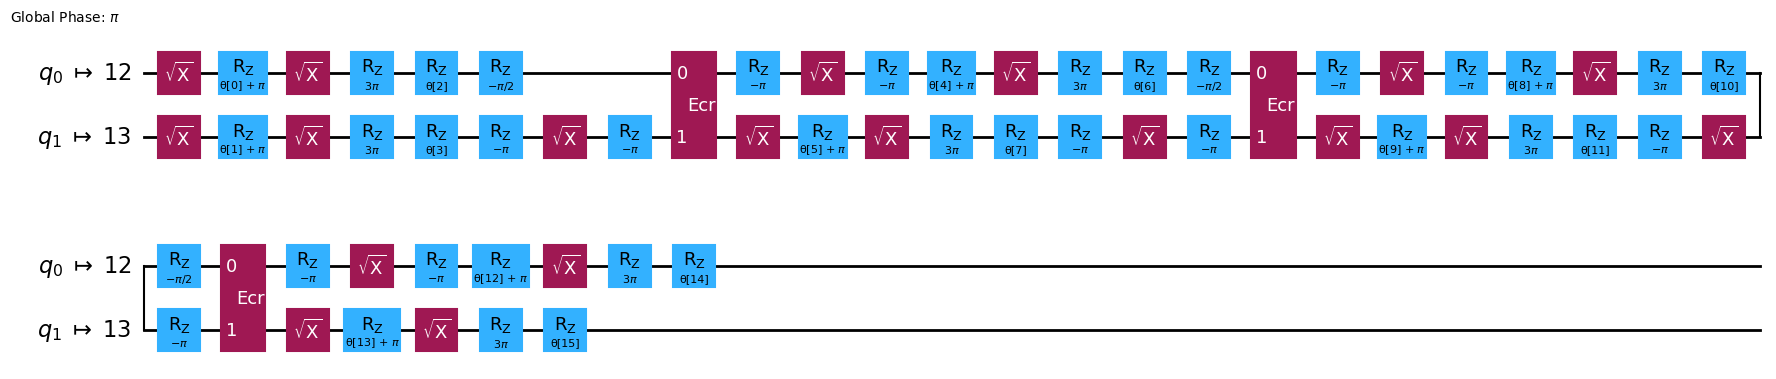

In [ ]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

#### ISA observable

In [ ]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

Transform the Hamiltonian to make it backend-compatible before running jobs with 
Runtime Estimator V2 Perform the transformation by using the apply_layout method of SparsePauliOp object.

### Step 3: Execute using Qiskit Primitives


In [ ]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [ ]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [ ]:
x0 = 2 * np.pi * np.random.random(num_params)

In [ ]:
x0

array([1.99729101, 2.49795483, 5.75671752, 5.05653113, 2.88008001,
       4.06973373, 4.92238642, 5.53657026, 6.18821218, 5.03557516,
       0.15113799, 0.91847491, 4.89147661, 2.45093727, 1.53223398,
       0.86804292])

In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

/tmp/ipykernel_21343/1765566785.py:2: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


Iters. done: 1 [Current cost: -0.28532481494093687]
Iters. done: 2 [Current cost: -0.15378887458701193]
Iters. done: 3 [Current cost: -0.3716250440907221]
Iters. done: 4 [Current cost: -0.15069486844983201]
Iters. done: 5 [Current cost: -0.37544930062512744]
Iters. done: 6 [Current cost: -0.5266103871866816]
Iters. done: 7 [Current cost: -0.22580481342293965]
Iters. done: 8 [Current cost: -0.4079944827998275]
Iters. done: 9 [Current cost: -0.40437757701868443]
Iters. done: 10 [Current cost: -0.42852216342634347]
Iters. done: 11 [Current cost: -0.3552201199446565]
Iters. done: 12 [Current cost: -0.3833844059628258]
Iters. done: 13 [Current cost: -0.3940719970831176]
Iters. done: 14 [Current cost: -0.37915116285059347]
Iters. done: 15 [Current cost: -0.2776476492307279]
Iters. done: 16 [Current cost: -0.5798421230711293]
Iters. done: 17 [Current cost: -0.5413653554964403]
Iters. done: 18 [Current cost: -0.5655050783836677]
Iters. done: 19 [Current cost: -0.49448521607436585]
Iters. done:

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.6799004481973263
       x: [ 2.016e+00  3.651e+00 ...  2.937e+00  9.882e-01]
    nfev: 176
   maxcv: 0.0

### Step 4: Post-process, return result in classical format

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [ ]:
cost_history_dict["iters"] == res.nfev

True

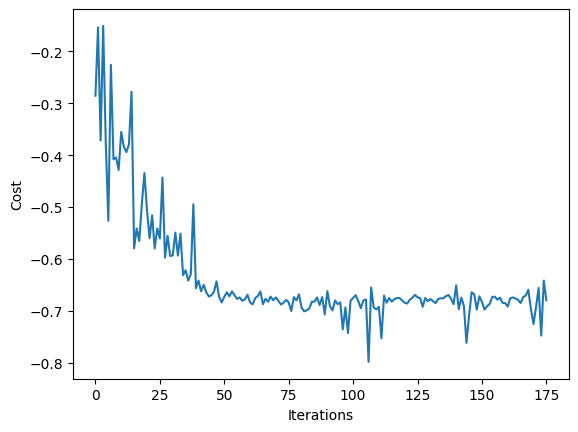

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.25.0'

In [ ]:
import qiskit

qiskit.version.get_version_info()

'1.1.1'

## Use Case

1. Compute the interatomic distance of a molecule

## Citation

[Variational quantum eigensolver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)


[The Variational Quantum Eigensolver — Programming on Quantum Computers — Coding with Qiskit S2E4](https://youtu.be/Z-A6G0WVI9w?feature=shared)

# Quantum Approximate Optimization Algorithm (QAOA):

## What is it

An algorithm designed for solving combinatorial optimization problems.